In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [4]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [5]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [6]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    startTime = time.time()
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    endTime = time.time()
    #print(endTime - startTime)
    return (lp + ll)

In [ ]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

In [ ]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

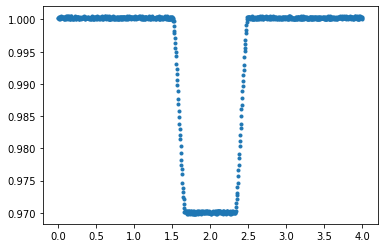

8 CPUs


In [7]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,0.8)
fluxErr = 0.0005*np.ones(1000)
flux = flux + np.random.random(1000)*fluxErr
fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
plt.show()

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

In [8]:
pos = [10,10,1,2,1] * np.ones([16,5]) + 4*np.random.random([16,5]) - 2
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr), pool = pool)
    sampler.run_mcmc(pos,5000, progress = True)

  0%|                                                                                   | 0/10000 [00:00<?, ?it/s]/home/jbromley/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 19%|█████████████▌                                                        | 1944/10000 [18:10<1:15:20,  1.78it/s]Process ForkPoolWorker-4:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-8:


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-6:


Traceback (most recent call last):


  params:

Process ForkPoolWorker-1:
Traceback (most recent call last):


  params:

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


   params:


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


  params:

  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


[10.31078761 10.13400494  1.00223308  1.99768679  0.79324674][10.10374544 10.06609754  0.99735282  2.00013179  0.79458189] 

  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


  args:

  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


[10.08337945  9.84288505  1.00331438  1.99776449  0.79251026]

  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


   args:

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


[10.03360529 10.39106789  0.99770111  1.99874688  0.76534683]

  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt


  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


  args:

KeyboardInterrupt


   args:

KeyboardInterrupt


  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


(array([0.        , 0.004004  , 0.00800801, 0.01201201, 0.01601602,
       0.02002002, 0.02402402, 0.02802803, 0.03203203, 0.03603604,
       0.04004004, 0.04404404, 0.04804805, 0.05205205, 0.05605606,
       0.06006006, 0.06406406, 0.06806807, 0.07207207, 0.07607608,
       0.08008008, 0.08408408, 0.08808809, 0.09209209, 0.0960961 ,
       0.1001001 , 0.1041041 , 0.10810811, 0.11211211, 0.11611612,
       0.12012012, 0.12412412, 0.12812813, 0.13213213, 0.13613614,
       0.14014014, 0.14414414, 0.14814815, 0.15215215, 0.15615616,
       0.16016016, 0.16416416, 0.16816817, 0.17217217, 0.17617618,
       0.18018018, 0.18418418, 0.18818819, 0.19219219, 0.1961962 ,
       0.2002002 , 0.2042042 , 0.20820821, 0.21221221, 0.21621622,
       0.22022022, 0.22422422, 0.22822823, 0.23223223, 0.23623624,
       0.24024024, 0.24424424, 0.24824825, 0.25225225, 0.25625626,
       0.26026026, 0.26426426, 0.26826827, 0.27227227, 0.27627628,
       0.28028028, 0.28428428, 0.28828829, 0.29229229, 0.2962

  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


(array([0.        , 0.004004  , 0.00800801, 0.01201201, 0.01601602,
       0.02002002, 0.02402402, 0.02802803, 0.03203203, 0.03603604,
       0.04004004, 0.04404404, 0.04804805, 0.05205205, 0.05605606,
       0.06006006, 0.06406406, 0.06806807, 0.07207207, 0.07607608,
       0.08008008, 0.08408408, 0.08808809, 0.09209209, 0.0960961 ,
       0.1001001 , 0.1041041 , 0.10810811, 0.11211211, 0.11611612,
       0.12012012, 0.12412412, 0.12812813, 0.13213213, 0.13613614,
       0.14014014, 0.14414414, 0.14814815, 0.15215215, 0.15615616,
       0.16016016, 0.16416416, 0.16816817, 0.17217217, 0.17617618,
       0.18018018, 0.18418418, 0.18818819, 0.19219219, 0.1961962 ,
       0.2002002 , 0.2042042 , 0.20820821, 0.21221221, 0.21621622,
       0.22022022, 0.22422422, 0.22822823, 0.23223223, 0.23623624,
       0.24024024, 0.24424424, 0.24824825, 0.25225225, 0.25625626,
       0.26026026, 0.26426426, 0.26826827, 0.27227227, 0.27627628,
       0.28028028, 0.28428428, 0.28828829, 0.29229229, 0.2962

  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


  kwargs:

  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt


{}

  kwargs:  exception:
 {}


Traceback (most recent call last):


  exception:(array([0.        , 0.004004  , 0.00800801, 0.01201201, 0.01601602,
       0.02002002, 0.02402402, 0.02802803, 0.03203203, 0.03603604,
       0.04004004, 0.04404404, 0.04804805, 0.05205205, 0.05605606,
       0.06006006, 0.06406406, 0.06806807, 0.07207207, 0.07607608,
       0.08008008, 0.08408408, 0.08808809, 0.09209209, 0.0960961 ,
       0.1001001 , 0.1041041 , 0.10810811, 0.11211211, 0.11611612,
       0.12012012, 0.12412412, 0.12812813, 0.13213213, 0.13613614,
       0.14014014, 0.14414414, 0.14814815, 0.15215215, 0.15615616,
       0.16016016, 0.16416416, 0.16816817, 0.17217217, 0.17617618,
       0.18018018, 0.18418418, 0.18818819, 0.19219219, 0.1961962 ,
       0.2002002 , 0.2042042 , 0.20820821, 0.21221221, 0.21621622,
       0.22022022, 0.22422422, 0.22822823, 0.23223223, 0.23623624,
       0.24024024, 0.24424424, 0.24824825, 0.25225225, 0.25625626,
       0.26026026, 0.26426426, 0.26826827, 0.27227227, 0.27627628,
       0.28028028, 0.28428428, 0.28828829, 0.2922

  File "/home/jbromley/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/tmp/ipykernel_1735/1108449271.py", line 13, in logProbability
    ll = logLikelihood(theta, times, flux, fluxErr)



  kwargs: 

  File "/tmp/ipykernel_1735/2427836434.py", line 15, in logLikelihood
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
Traceback (most recent call last):
  File "/tmp/ipykernel_1735/2935643225.py", line 28, in transitSim
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
  File "/home/jbromley/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)


{}

  File "/tmp/ipykernel_1735/2006495845.py", line 6, in generateEllipse
    grid[x][y] = opacity


  File "/tmp/ipykernel_1735/1108449271.py", line 13, in logProbability
    ll = logLikelihood(theta, times, flux, fluxErr)


  exception:

  File "/tmp/ipykernel_1735/2427836434.py", line 15, in logLikelihood
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)


  File "/tmp/ipykernel_1735/2935643225.py", line 29, in transitSim
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)


(array([0.        , 0.004004  , 0.00800801, 0.01201201, 0.01601602,
       0.02002002, 0.02402402, 0.02802803, 0.03203203, 0.03603604,
       0.04004004, 0.04404404, 0.04804805, 0.05205205, 0.05605606,
       0.06006006, 0.06406406, 0.06806807, 0.07207207, 0.07607608,
       0.08008008, 0.08408408, 0.08808809, 0.09209209, 0.0960961 ,
       0.1001001 , 0.1041041 , 0.10810811, 0.11211211, 0.11611612,
       0.12012012, 0.12412412, 0.12812813, 0.13213213, 0.13613614,
       0.14014014, 0.14414414, 0.14814815, 0.15215215, 0.15615616,
       0.16016016, 0.16416416, 0.16816817, 0.17217217, 0.17617618,
       0.18018018, 0.18418418, 0.18818819, 0.19219219, 0.1961962 ,
       0.2002002 , 0.2042042 , 0.20820821, 0.21221221, 0.21621622,
       0.22022022, 0.22422422, 0.22822823, 0.23223223, 0.23623624,
       0.24024024, 0.24424424, 0.24824825, 0.25225225, 0.25625626,
       0.26026026, 0.26426426, 0.26826827, 0.27227227, 0.27627628,
       0.28028028, 0.28428428, 0.28828829, 0.29229229, 0.2962

       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]))


Traceback (most recent call last):


  kwargs:

  File "/tmp/ipykernel_1735/2006495845.py", line 5, in generateEllipse
    if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
  File "/home/jbromley/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
KeyboardInterrupt
  File "/tmp/ipykernel_1735/1108449271.py", line 13, in logProbability
    ll = logLikelihood(theta, times, flux, fluxErr)


Process ForkPoolWorker-2:
KeyboardInterrupt


{}

  File "/tmp/ipykernel_1735/2427836434.py", line 15, in logLikelihood
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)



  File "/tmp/ipykernel_1735/2935643225.py", line 28, in transitSim
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
Process ForkPoolWorker-7:


  exception:

  File "/tmp/ipykernel_1735/2006495845.py", line 6, in generateEllipse
    grid[x][y] = opacity


Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-5:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jbromley/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_1735/1108449271.py", line 13, in logProbability
    ll = logLikelihood(theta, times, flux, fluxErr)
  File "/usr/lib/python3.7/multiprocessi

KeyboardInterrupt: 

In [ ]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(6,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
logProb = sampler.get_log_prob()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time", "Opacity"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[5].plot(logProb[:,:],'k',alpha = 0.3)
axes[5].set_xlim(0,len(samples))
axes[-1].set_xlabel("Step Number")
plt.show()

In [ ]:
fig = plt.subplot()
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    try:
        sample = flat_samples[ind]
        sampleFlux = transitSim(sample[0],sample[1],50,sample[2],times,sample[3],1)
        fig.plot(times,sampleFlux,alpha = 0.1)
    except:
        print("Invalid parameters")
    
    
fig.plot(times,flux)
plt.show()
    

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)